In [10]:
# import sys
# !conda install --yes --prefix {sys.prefix} pingouin

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pandas as pd
import pingouin as pg
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import sys

if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
    
from IPython.display import HTML
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))    
    
print("Current Working directory " , os.getcwd())

Current Working directory  C:\Users\User\GitHub\WebET_Analysis


In [17]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true; 
# function code_toggle() {
#  if (code_show){
#  $('div.input').hide();
#  } else {
#  $('div.input').show();
#  }
#  code_show = !code_show
# } 
# $( document ).ready(code_toggle);
# </script>
# <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Read data

In [18]:
data_et = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_et.csv')
data_trial = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_trial.csv')
data_subject = pd.read_csv(r'C:/Users/User/GitHub/WebET_Analysis/data_jupyter/data_subject.csv')

overview = pd.DataFrame(
    [
        [len(data_et)],
        [len(data_trial)],
        [len(data_subject)]
    ], 
    columns=['length'],
    index=[
        'data_et', 
        'data_trial', 
        'data_subject'
          ]
)
print(overview)

              length
data_et       618566
data_trial     30362
data_subject      40


# Create datasets

In [19]:
data_trial.columns

Index(['run_id', 'subject', 'prolificID', 'chinFirst', 'trial_index',
       'trial_type', 'task_nr', 'rt', 'stimulus', 'key_press', 'time_elapsed',
       'trial_duration', 'recorded_at', 'window_width', 'window_height',
       'success', 'chin', 'x_pos', 'y_pos', 'choiceTask_amountLeftFirst',
       'option_topLeft', 'option_bottomLeft', 'option_topRight',
       'option_bottomRight', 'chosenAmount', 'chosenDelay', 'window_width_max',
       'window_height_max', 'window_diagonal_max', 'window_diagonal',
       't_startTrial', 'trial_duration_exact', 'withinTaskIndex', 'x_count',
       'fps'],
      dtype='object')

In [20]:
data_trial_fixCal_raw = data_trial.loc[
    data_trial['trial_type'].isin(['eyetracking-calibration', 'eyetracking-fix-object']),
    [
        'run_id', 'chinFirst', 
        'trial_type', 'trial_index', 'withinTaskIndex', 
        'trial_duration', 'trial_duration_exact',
        'chin', 'x_pos', 'y_pos', 'task_nr',
        'window_height', 'window_width']
].reset_index(drop=True)

In [21]:
data_trial_calibration_raw = data_trial_fixCal_raw.loc[
    data_trial_fixCal_raw['trial_type']=='eyetracking-calibration', :]

data_et_calibration_raw = data_et_fixCal_raw.loc[
    data_et_fixCal_raw['trial_type']=='eyetracking-calibration', :]

data_trial_fix_raw = data_trial_fixCal_raw.loc[
    (data_trial_fixCal_raw['trial_type']=='eyetracking-fix-object') & 
    (data_trial_fixCal_raw['trial_duration']==5000), 
    :]

temp = data_et_fixCal_raw.merge(
    data_trial_fixCal_raw.loc[:, ['run_id', 'trial_index', 'trial_duration']],
    on=['run_id', 'trial_index'],
    how='left'
)
data_et_fix_raw = temp.loc[
    (temp['trial_type']=='eyetracking-fix-object') &
    (temp['trial_duration']==5000), 
    :
]

# Cleaning

## data_subject survey information

In [22]:
data_subject['degree'] = data_subject['degree'].replace({'0': np.nan, '-3.0': np.nan})

## Enough trials?

In [23]:
NTrials = data_trial_fixCal_raw.groupby(['run_id'])['trial_index'].max() \
    .reset_index()
subjects_not_enough_trials = NTrials.loc[NTrials['trial_index']<400, 'run_id']
print('These subjects do not have enough trials: \n' + 
      str(NTrials.loc[NTrials['trial_index']<400, :])
     )

These subjects do not have enough trials: 
    run_id  trial_index
27      61        271.0
55    2002         99.0
57    2009        255.0
58    2011         32.0


## Followed instructions? 

In [24]:
data_subject.loc[
    (data_subject['keptHead']==0) |
    (data_subject['triedChin']==0), 
    ['run_id', 'prolificID', 'keptHead', 'triedChin']
]

,run_id,prolificID,keptHead,triedChin


## filter

In [25]:
cleanSubjects = data_subject.loc[
        (data_subject['status']=='APPROVED') &
        (data_subject['keptHead']!=0) &
        (data_subject['triedChin']!=0) &
        pd.notna(data_subject['fps']) &
        ~(data_subject['run_id'].isin(subjects_not_enough_trials)), 
        'run_id'
    ].unique()
cleanSubjects

array([103,  11, 126, 128,  13, 130, 131,  19,  24,  25,  28,  30,  32,
        36,  37,   4,  41,  42,  43,  45,  47,   5,  58,  59,   6,  63,
        66,  67,   7,  70,  74,  80,  81,  85,  91,  92,  93,  94,  96,
        97], dtype=int64)

### trial data

In [26]:
data_trial_fixCal = data_trial_fixCal_raw.loc[
    data_trial_fixCal_raw['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial_fixCal')
print('raw: ' + str(len(data_trial_fixCal_raw)))
print('cleaned: ' + str(len(data_trial_fixCal)))

data_trial_fixCal
raw: 11234
cleaned: 7710


In [27]:
data_trial_calibration = data_trial_calibration_raw.loc[
    data_trial_calibration_raw['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial_calibration')
print('raw: ' + str(len(data_trial_calibration_raw)))
print('cleaned: ' + str(len(data_trial_calibration)))

data_trial_calibration
raw: 4545
cleaned: 3088


In [28]:
data_trial_fix = data_trial_fix_raw.loc[
    data_trial_fix_raw['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)

print('data_trial_fix')
print('raw: ' + str(len(data_trial_fix_raw)))
print('cleaned: ' + str(len(data_trial_fix)))

data_trial_fix
raw: 1044
cleaned: 711


### et data

In [29]:
def cleanETData(data, cleanSubjects):
    return data.loc[
        (data['x']>0) & (data['x']<1) &(data['y']>0) & (data['y']<1) &
        (data['run_id'].isin(cleanSubjects)), :] \
        .reset_index(drop=True)

data_et_fixCal = cleanETData(data_et_fixCal_raw, cleanSubjects)

print('data_et_fixCal')
print('raw: ' + str(len(data_et_fixCal_raw)))
print('cleaned: ' + str(len(data_et_fixCal)))

data_et_fixCal
raw: 462562
cleaned: 353046


In [30]:
data_et_calibration = cleanETData(data_et_calibration_raw, cleanSubjects)

print('data_et_calibration')
print('raw: ' + str(len(data_et_calibration_raw)))
print('cleaned: ' + str(len(data_et_calibration)))

data_et_calibration
raw: 277038
cleaned: 208384


In [31]:
data_et_fix = cleanETData(data_et_fix_raw, cleanSubjects)
data_et_fix = data_et_fix.loc[
    (data_et_fix['t_task']>1000) &
    (data_et_fix['t_task']<5001)
] \
    .reset_index(drop=True)
print('data_et_fix')
print('raw: ' + str(len(data_et_fix_raw)))
print('cleaned: ' + str(len(data_et_fix)))

data_et_fix
raw: 81877
cleaned: 50976


In [32]:
print('data_subject raw: ' + str(len(data_subject)))
data_subject = data_subject.loc[data_subject['run_id'].isin(cleanSubjects), :] \
    .reset_index(drop=True)
print('data_subject cleaned: ' + str(len(data_subject)))
data_subject['webcam_fps'] = np.round(data_subject['webcam_fps'])

data_subject raw: 40
data_subject cleaned: 40


# Add variables

## Position index

In [33]:
def multiply(x):
    return x*100

def positionIndex(data):
    allPositionIndices = []
    for subject in data["run_id"].unique():
        df_subj = data.loc[
                (data['run_id']==subject) &
                (data['trial_type'].isin(['eyetracking-calibration', 'eyetracking-fix-object'])), 
            :]
        
        for trial_type in df_subj['trial_type'].unique():
            df_trial = df_subj.loc[df_subj['trial_type']==trial_type, :]
                
            for task_nr in df_trial["task_nr"].unique():
                df_thisTask = df_trial.loc[
                        df_trial['task_nr']==task_nr, 
                        ['run_id', 'trial_index', 'x_pos', 'y_pos']
                    ] \
                    .drop_duplicates() \
                    .reset_index(drop=True)

                df_thisTask['positionIndex'] = df_thisTask.loc[:, ['x_pos', 'y_pos']] \
                    .apply(multiply) \
                    .astype(int) \
                    .astype(str) \
                    .apply(''.join, 1)
                df_thisTask['positionIndex'] = df_thisTask['positionIndex'].astype(int)
                df_thisTask['positionIndex'] = df_thisTask.loc[:, 'positionIndex'] \
                    .replace(
                            np.sort(df_thisTask['positionIndex'].unique()), 
                            range(0, len(df_thisTask['positionIndex'].unique()))
                        )        
                allPositionIndices.append(df_thisTask)
                
    allPositionIndices = pd.concat(allPositionIndices).reset_index(drop=True)
    return allPositionIndices

def addPositionIndex(data):
    if 'positionIndex' in data.columns: 
        print('positionIndex already added')
    else:
        newIndices = positionIndex(data) \
            .reset_index(drop=True)
        data = data.merge(newIndices, 
                          on = ['run_id', 'trial_index', 'x_pos', 'y_pos'], 
                          how = 'left')
    return data

data_trial_fixCal = addPositionIndex(data_trial_fixCal)
data_trial_fix = addPositionIndex(data_trial_fix)

## Offset

### Calculate on gaze point-level

In [34]:
def euclideanDistance(x, x_target, y, y_target):
    x_diff = x - x_target
    y_diff = y - y_target
    euclideanDistance = np.sqrt(x_diff**2 + y_diff**2)
    return(euclideanDistance)

def offset(data):
    offset = euclideanDistance(
        data["x"], data['x_pos'],
        data["y"], data['y_pos'])
    return(offset)

data_et_fixCal_raw.loc[:, "offset"] = offset(data_et_fixCal_raw)
data_et_fixCal.loc[:, "offset"] = offset(data_et_fixCal)
data_et_calibration_raw.loc[:, "offset"] = offset(data_et_calibration_raw)
data_et_calibration.loc[:, "offset"] = offset(data_et_calibration)
data_et_fix_raw.loc[:, "offset"] = offset(data_et_fix_raw)
data_et_fix.loc[:, "offset"] = offset(data_et_fix)

C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Aggregate on trial level

In [35]:
def merge_offset_by_index(data, data_et):
    if 'offset' in data.columns: 
        data = data.drop(columns=['offset'])
    grouped = data_et.groupby(['run_id', 'trial_index'])['offset'].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left')
    return data

data_trial_fixCal = merge_offset_by_index(data_trial_fixCal, data_et_fixCal)
data_trial_fixCal_raw = merge_offset_by_index(data_trial_fixCal_raw, data_et_fixCal_raw)
data_trial_calibration = merge_offset_by_index(data_trial_calibration, data_et_calibration)
data_trial_calibration_raw = merge_offset_by_index(data_trial_calibration_raw, data_et_calibration_raw)
data_trial_fix = merge_offset_by_index(data_trial_fix, data_et_fix)
data_trial_fix_raw = merge_offset_by_index(data_trial_fix_raw, data_et_fix_raw)

### Aggregate on subject-level 

In [36]:
def merge_by_subject(data, large_data, varName):
    if varName in data.columns: data = data.drop(columns=[varName])
    grouped = large_data.groupby(['run_id'])[varName].mean() \
        .reset_index()        
    data = data.merge(grouped, on=['run_id'], how='left')
    return data

data_subject = merge_by_subject(data_subject, data_trial_fix, 'offset')

def separate_outcomes_chin_condition(data, large_data, varName):
    var_chin_0 = varName + '_chin_0' 
    var_chin_1 = varName + '_chin_1' 
    
    if var_chin_0 in data.columns: data = data.drop(columns=[var_chin_0])
    if var_chin_1 in data.columns: data = data.drop(columns=[var_chin_1])
        
    grouped = large_data \
        .groupby(['run_id', 'chin'])[varName].mean() \
        .reset_index() \
        .pivot(index='run_id', columns='chin', values=varName) \
        .reset_index() \
        .rename(columns={0.0: var_chin_0, 1.0: var_chin_1}) 
    data = data.merge(grouped.loc[:, ['run_id', var_chin_0, var_chin_1]], on='run_id', how='left')
    return data

data_subject = separate_outcomes_chin_condition(data_subject, data_trial_fix, 'offset')
data_subject.loc[:, ['offset', 'offset_chin_0', 'offset_chin_1']].describe()

,offset,offset_chin_0,offset_chin_1
count,40.000000,39.000000,40.000000
mean,0.179135,0.169092,0.181398
std,0.114421,0.103116,0.123710
min,0.074476,0.069445,0.058743
25%,0.104293,0.091836,0.106928
50%,0.144662,0.143973,0.142165
75%,0.214125,0.205198,0.201157
max,0.644614,0.586669,0.702559


## Precision

### Distance from AVG on et-level

In [37]:
def merge_xy_means(data):    
    if 'x_mean' in data.columns: 
        data = data.drop(columns=['x_mean'])
    if 'y_mean' in data.columns: 
        data = data.drop(columns=['y_mean'])

    grouped = data.groupby(['run_id', 'trial_index'])['x', 'y'].mean() \
        .rename(columns={'x': 'x_mean', 'y': 'y_mean'})
    data = data.merge(grouped, on=['run_id', 'trial_index'], how='left') 
    return(data)

def distanceFromAVG(data):
    data = merge_xy_means(data)
    distanceFromAVG = euclideanDistance(data['x'], data['x_mean'], data['y'], data['y_mean'])
    return(distanceFromAVG)    

data_et_fixCal.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fixCal), 2)
data_et_fixCal_raw.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fixCal_raw), 2)
data_et_calibration_raw.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_calibration_raw), 2)
data_et_calibration.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_calibration), 2)
data_et_fix_raw.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fix_raw), 2)
data_et_fix.loc[:, 'distanceFromAVG_square'] = np.power(distanceFromAVG(data_et_fix), 2)

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### Standard deviation of gaze points on trial-level

In [38]:
def addPrecision(data, data_et):
    if 'precision' in data.columns: 
        data = data.drop(columns=['precision'])
    grouped = data_et \
        .groupby(['run_id', 'trial_index'])['distanceFromAVG_square'].mean() \
        .reset_index()
    grouped['precision'] = np.sqrt(grouped['distanceFromAVG_square'])
    data = data.merge(grouped.loc[:, ['run_id', 'trial_index', 'precision']], 
                      on=['run_id', 'trial_index'], 
                      how='left')
    return(data)

data_trial_fixCal = addPrecision(data_trial_fixCal, data_et_fixCal)
data_trial_fixCal_raw = addPrecision(data_trial_fixCal_raw, data_et_fixCal_raw)
data_trial_calibration = addPrecision(data_trial_calibration, data_et_calibration)
data_trial_calibration_raw = addPrecision(data_trial_calibration_raw, data_et_calibration_raw)
data_trial_fix = addPrecision(data_trial_fix, data_et_fix)
data_trial_fix_raw = addPrecision(data_trial_fix_raw, data_et_fix_raw)

### Aggregate on subject-level 

In [39]:
data_subject = merge_by_subject(data_subject, data_trial_fix, 'precision')
data_subject = separate_outcomes_chin_condition(data_subject, data_trial_fix, 'precision')
data_subject.loc[:, ['precision', 'precision_chin_0', 'precision_chin_1']].describe()

,precision,precision_chin_0,precision_chin_1
count,40.000000,39.000000,40.000000
mean,0.072441,0.076815,0.069988
std,0.025306,0.021904,0.029770
min,0.000000,0.032130,0.000000
25%,0.058172,0.062395,0.053577
50%,0.069413,0.072938,0.064983
75%,0.087232,0.086595,0.083420
max,0.148123,0.132984,0.182229


# Gaze predictions

## For each position

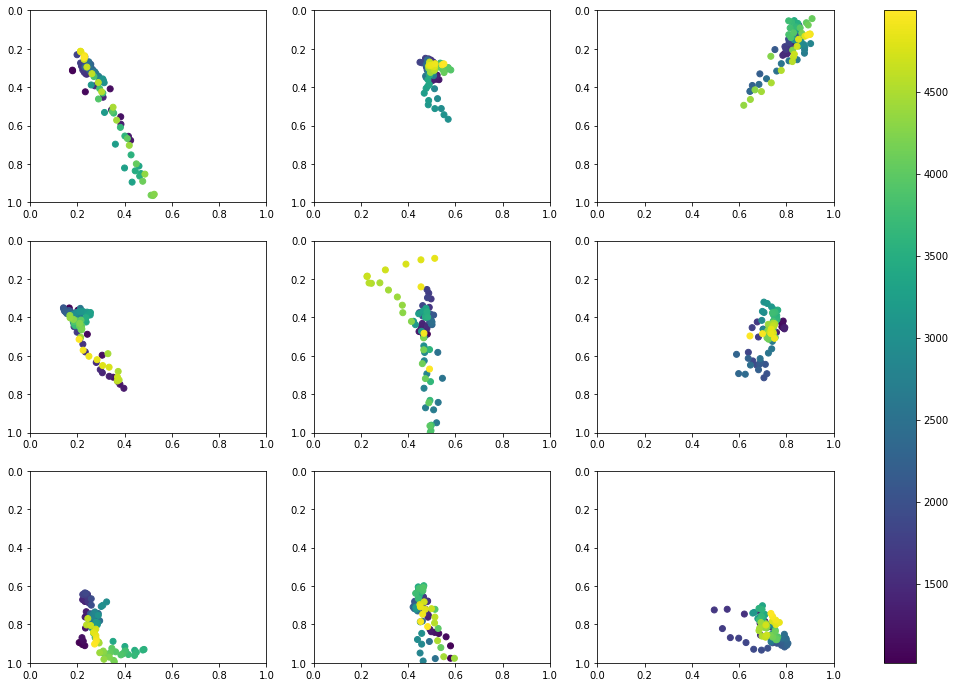

In [40]:
data_plot = data_et_fix.merge(data_trial_fix_raw.loc[:, ['run_id', 'trial_index', 'chin']], 
                             on=['run_id', 'trial_index'], 
                             how='left')

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()
xPos = [0.2, 0.5, 0.8, 0.2, 0.5, 0.8, 0.2, 0.5, 0.8]
yPos = [0.2, 0.2, 0.2, 0.5, 0.5, 0.5, 0.8, 0.8, 0.8]
for i in range(0, 9):
    axes_data = data_plot.loc[
        (data_plot['run_id']==103) & 
        (data_plot['chin']==0) &
        (data_plot['x_pos']==xPos[i]) & 
        (data_plot['y_pos']==yPos[i]), 
        :]
    im = axes[i].scatter(
        axes_data['x'], 
        axes_data['y'], 
        c=axes_data['t_task'], 
        cmap='viridis'
    )
    axes[i].set_ylim(1, 0)
    axes[i].set_xlim(0, 1)
    
fig.colorbar(im, ax=axes)
plt.show()

# Offset & precision

## Chin-rest conditions

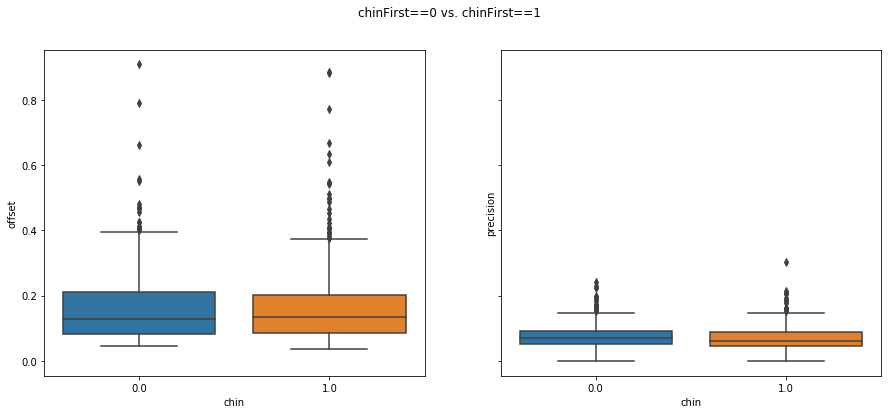

In [41]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', data=data_trial_fix)
sns.boxplot(ax=axes[1], x='chin', y='precision', data=data_trial_fix)
   
plt.show()

In [42]:
means_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].mean() \
    .reset_index() \
    .rename(columns={0: 'mean'})
var_0 = data_subject.loc[:, ['offset_chin_0', 'offset_chin_1', 'precision_chin_0', 'precision_chin_1']].var() \
    .reset_index() \
    .rename(columns={0: 'var'})
means_0.merge(var_0, on='index', how='left')

,index,mean,var
0,offset_chin_0,0.169092,0.010633
1,offset_chin_1,0.181398,0.015304
2,precision_chin_0,0.076815,0.000480
3,precision_chin_1,0.069988,0.000886


In [43]:
scipy.stats.ttest_rel(data_subject['offset_chin_0'], data_subject['offset_chin_1'])

C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\User\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Ttest_relResult(statistic=nan, pvalue=nan)

### ChinFirst

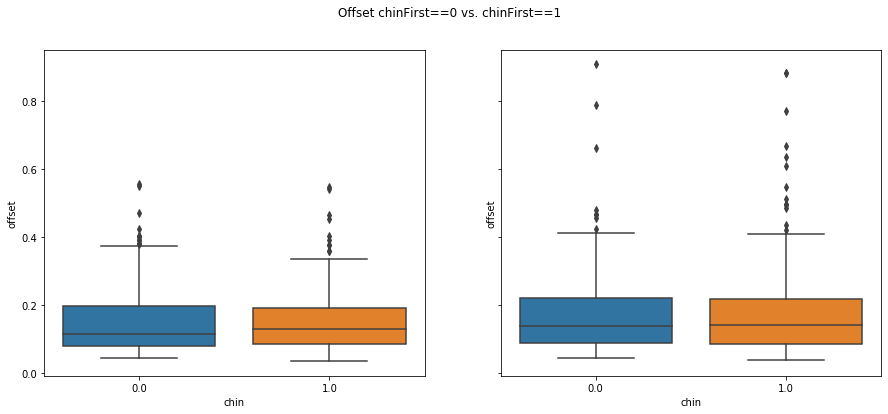

In [44]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Offset chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='offset', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

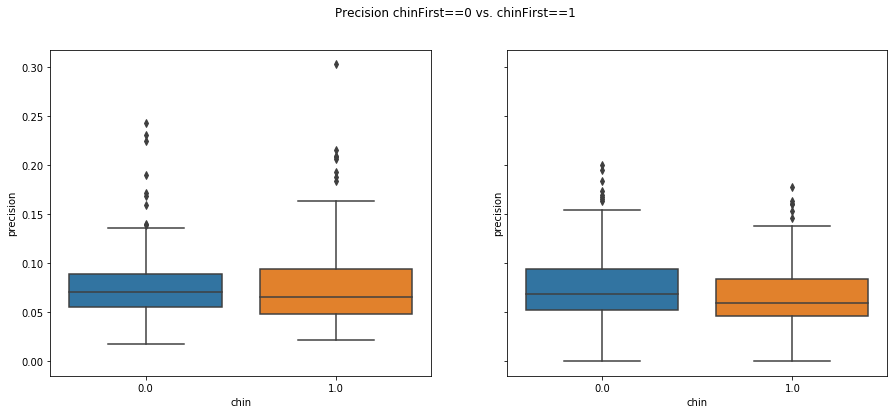

In [45]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(15,6))
fig.suptitle('Precision chinFirst==0 vs. chinFirst==1')

sns.boxplot(ax=axes[0], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==0, :])
sns.boxplot(ax=axes[1], x='chin', y='precision', 
            data=data_trial_fix.loc[data_trial_fix['chinFirst']==1, :])
   
plt.show()

### Fixation dot positions

In [46]:
grouped_var = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].var() \
    .rename(columns={'offset': 'offset_var', 'precision':'precision_var'}) \
    .reset_index()

grouped_means = data_trial_fix.groupby(['positionIndex', 'chin']) \
    ['offset', 'precision'].mean() \
    .reset_index()

grouped = grouped_means.merge(grouped_var, on=['positionIndex', 'chin'], how='left')

grouped_offset = grouped.loc[:, ['positionIndex', 'chin', 'offset']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_chin_0', 1.0: 'offset_chin_1'}) 

grouped_offset_var = grouped.loc[:, ['positionIndex', 'chin', 'offset_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['offset_var'] \
    .reset_index() \
    .rename(columns={0.0: 'offset_var_chin_0', 1.0: 'offset_var_chin_1'}) 

grouped_precision = grouped.loc[:, ['positionIndex', 'chin', 'precision']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_chin_0', 1.0: 'precision_chin_1'}) 

grouped_precision_var = grouped.loc[:, ['positionIndex', 'chin', 'precision_var']] \
    .set_index(['positionIndex']) \
    .pivot(columns="chin")['precision_var'] \
    .reset_index() \
    .rename(columns={0.0: 'precision_var_chin_0', 1.0: 'precision_var_chin_1'}) 

overview = pd.concat(
    [
        grouped_offset,
        grouped_offset_var.iloc[:, 1:3],
        grouped_precision.iloc[:, 1:3], 
        grouped_precision_var.iloc[:, 1:3]
    ], 
    axis=1
)

print(overview.mean(numeric_only=True))
overview

chin
positionIndex           4.000000
offset_chin_0           0.165476
offset_chin_1           0.172005
offset_var_chin_0       0.013481
offset_var_chin_1       0.016828
precision_chin_0        0.077216
precision_chin_1        0.071582
precision_var_chin_0    0.001204
precision_var_chin_1    0.001403
dtype: float64


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


chin,positionIndex,offset_chin_0,offset_chin_1,offset_var_chin_0,offset_var_chin_1,precision_chin_0,precision_chin_1,precision_var_chin_0,precision_var_chin_1
0,0,0.185200,0.178281,0.012992,0.010475,0.087751,0.075977,0.001827,0.001235
1,1,0.154817,0.174109,0.007832,0.017042,0.071629,0.073569,0.000705,0.001760
2,2,0.188193,0.207273,0.014363,0.018754,0.083105,0.071156,0.001990,0.001291
3,3,0.167982,0.169801,0.010763,0.011561,0.075945,0.074641,0.000941,0.001271
4,4,0.134428,0.142032,0.011242,0.015581,0.069093,0.063186,0.001371,0.001007
5,5,0.152300,0.163017,0.024465,0.025072,0.064675,0.065994,0.000635,0.001727
6,6,0.203890,0.177012,0.021448,0.018997,0.088647,0.080380,0.001346,0.001281
7,7,0.137490,0.168753,0.007843,0.021414,0.077883,0.068087,0.001137,0.000976
8,8,0.164983,0.167766,0.010381,0.012555,0.076216,0.071245,0.000881,0.002080


## Offset within trials, including fixation cross

In [69]:
def select_fixTask_and_fixCross(data):
    return data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        ((data['task_nr']==1) |
            ((data['chinFirst']==0) & (data['task_nr']==2)) |
            ((data['chinFirst']==1) & (data['task_nr']==3))
        ), :]. reset_index(drop=True)

data_et_fix_task_fixCross = select_fixTask_and_fixCross(
    data_et_fixCal.merge(
        data_trial_fixCal.loc[:, ['run_id', 'trial_index', 'task_nr', 'chinFirst', 'trial_duration', 'chin']], 
        on=['run_id', 'trial_index'], 
        how='left'
    )
)
data_trial_fix_task_fixCross = select_fixTask_and_fixCross(data_trial_fixCal)

In [70]:
def reformatTTask(data):                                                 
    data.loc[
        (data['trial_type']=='eyetracking-fix-object') & 
        (data['trial_duration']==1500), 
        't_task'
    ] = data.loc[
        (data['trial_type']=='eyetracking-fix-object') &
        (data['trial_duration']==1500), 
        't_task'
    ] - 1500
    return data

data_et_fix_task_fixCross = reformatTTask(data_et_fix_task_fixCross)

In [71]:
def add_next_xy_pos(data):
    data['next_x_pos']=0
    data['next_y_pos']=0
    for i in data.index:
        if data.loc[i, 'trial_duration']==1500:
            data.loc[i, 'next_x_pos'] = data.loc[i+1, 'x_pos']
            data.loc[i, 'next_y_pos'] = data.loc[i+1, 'y_pos']
    return(data)
data_trial_fix_task_fixCross = add_next_xy_pos(data_trial_fix_task_fixCross)

data_trial_fix_task_fixCross
data_et_fix_task_fixCross = data_et_fix_task_fixCross.merge(
    data_trial_fix_task_fixCross.loc[:, ['run_id', 'trial_index', 'next_x_pos', 'next_y_pos']],
    on=['run_id', 'trial_index'],
    how='left'
)

Index(['x', 'y', 't', 't_task', 'run_id', 'trial_index', 'trial_type', 'x_pos',
       'y_pos', 'offset', 'distanceFromAVG_square', 'task_nr', 'chinFirst',
       'trial_duration', 'chin', 'next_x_pos', 'next_y_pos'],
      dtype='object')


In [72]:
def new_distance_for_fixCross(data):
    data.loc[data['trial_duration']==1500, 'offset'] = euclideanDistance(
        data.loc[data['trial_duration']==1500, 'x'], 
        data.loc[data['trial_duration']==1500, 'next_x_pos'], 
        data.loc[data['trial_duration']==1500, 'y'], 
        data.loc[data['trial_duration']==1500, 'next_y_pos']
    )
    return data
        
data_et_fix_task_fixCross = new_distance_for_fixCross(data_et_fix_task_fixCross)

In [75]:
def createAVGLine(data):
    binArray = np.arange(-1500, 5000, 50)
    bins = pd.cut(data['t_task'], binArray)
    output = data.groupby(bins).agg({"offset": "median"}).reset_index()
    output['t_task'] = binArray[0:len(output)]
    return output

average_line_noChin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==0, :])
average_line_chin = createAVGLine(data_et_fix_task_fixCross.loc[data_et_fix_task_fixCross['chin']==1, :])

Text(0.5, 0, 't_task')

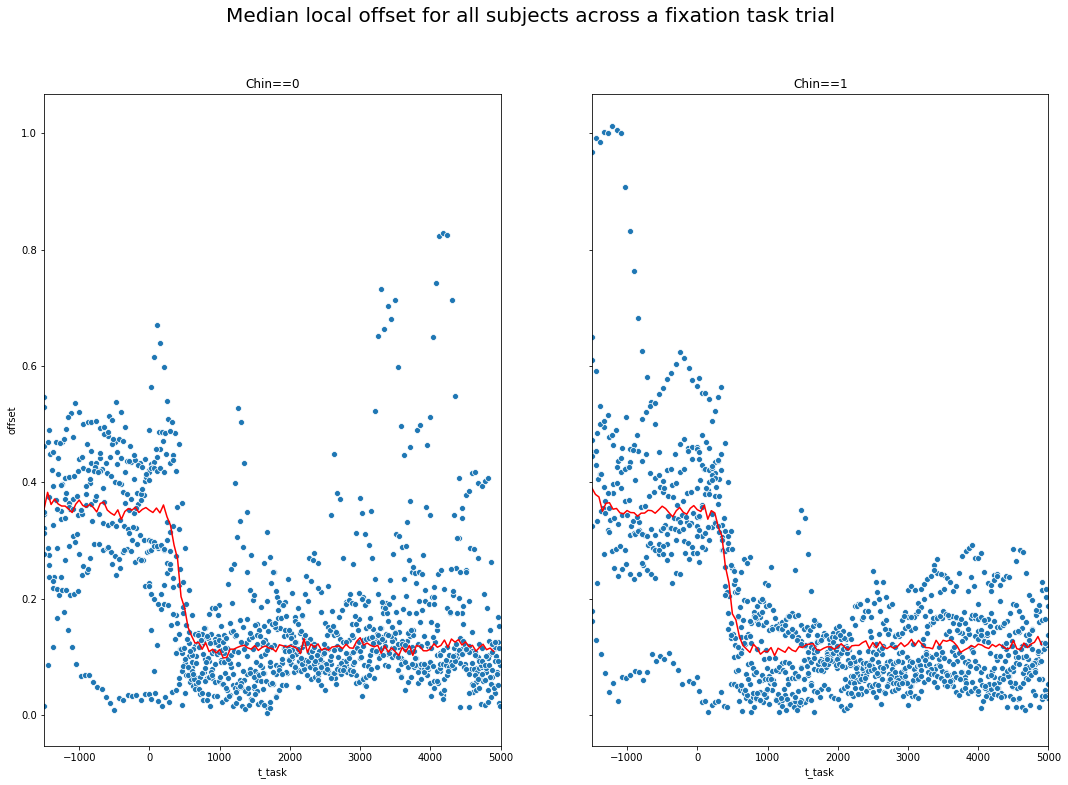

In [76]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(18, 12))
fig.suptitle('Median local offset for all subjects across a fixation task trial', fontsize=20)

axes[0].set_title("Chin==0")
axes[1].set_title("Chin==1")

sns.scatterplot(ax=axes[0], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==0), 
                    :], 
                x="t_task", y="offset")
sns.lineplot(ax=axes[0], x=average_line_noChin['t_task'], y=average_line_noChin['offset'], color='r')

sns.scatterplot(ax=axes[1], 
                data=data_et_fix_task_fixCross.loc[
                    (data_et_fix_task_fixCross['run_id']==103) & 
                    (data_et_fix_task_fixCross['chin']==1), 
                    :],
                x="t_task", y="offset")
sns.lineplot(ax=axes[1], x=average_line_chin['t_task'], y=average_line_chin['offset'], color='r')

plt.setp(axes, xlim=(-1500, 5000)) 
plt.xlabel("t_task")

## Calibration

### offset

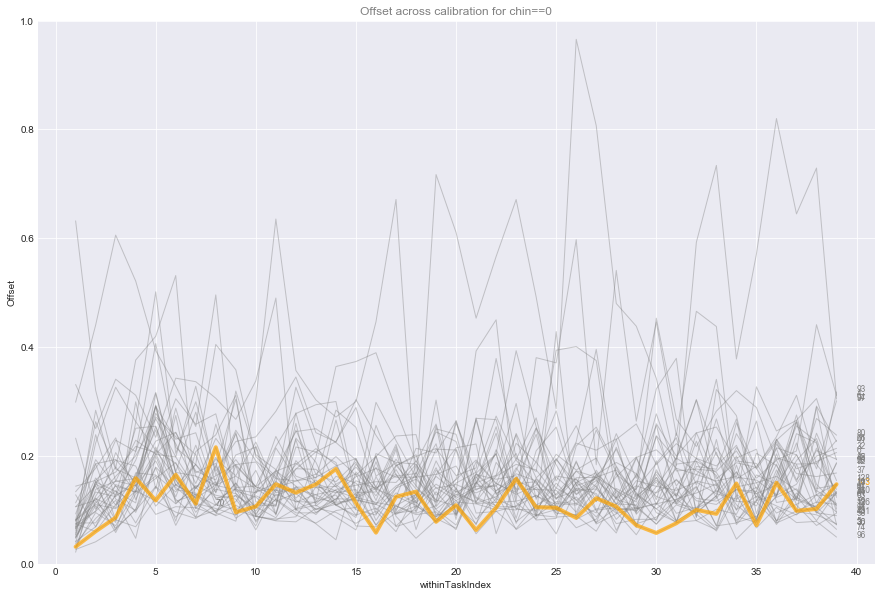

In [79]:
def spaghettiPlot(data, xVar, yVar, highlightedSubject):
    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(15, 10))

    # Draw Plots
    for subject in data["run_id"].unique():
        ax.plot(data.loc[data['run_id']==subject, xVar], 
                data.loc[data['run_id']==subject, yVar], 
                marker='', color='grey', linewidth=1, alpha=0.4)

    # Highlight Subject 
    ax.plot(data.loc[data['run_id']==highlightedSubject, xVar], 
            data.loc[data['run_id']==highlightedSubject, yVar], 
            marker='', color='orange', linewidth=4, alpha=0.7)

    # Let's annotate the plot
    for subject in data["run_id"].unique():
        if subject != highlightedSubject:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='grey')

        else:
            ax.text(data.loc[data['run_id']==subject, xVar].max()+1, 
                    data.loc[data['run_id']==subject, yVar].tail(1),
                    s=subject, horizontalalignment='left', size='small', color='orange')
    return plt

spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

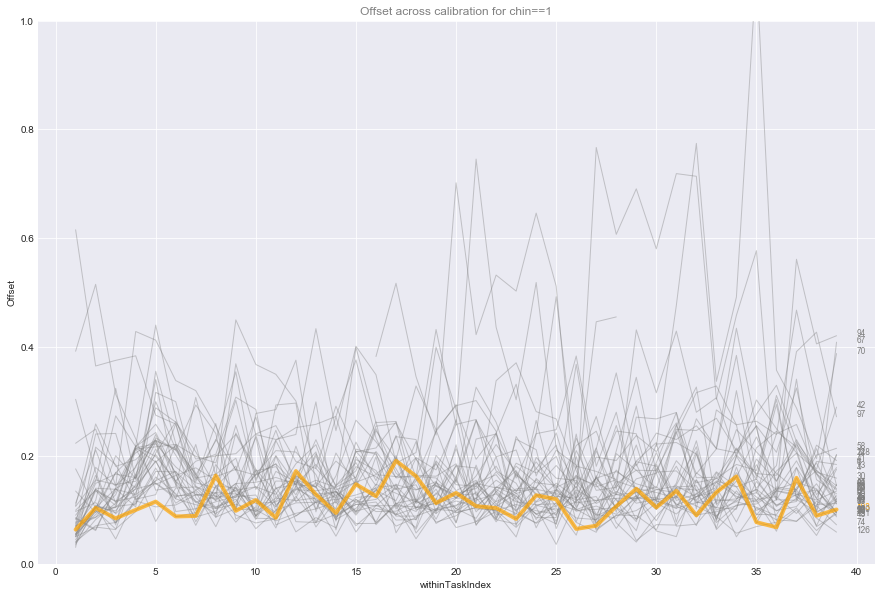

In [80]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'offset', 103)
plt.ylim(0, 1)
plt.title('Offset across calibration for chin==1', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Offset')

plt.show()

### Precision

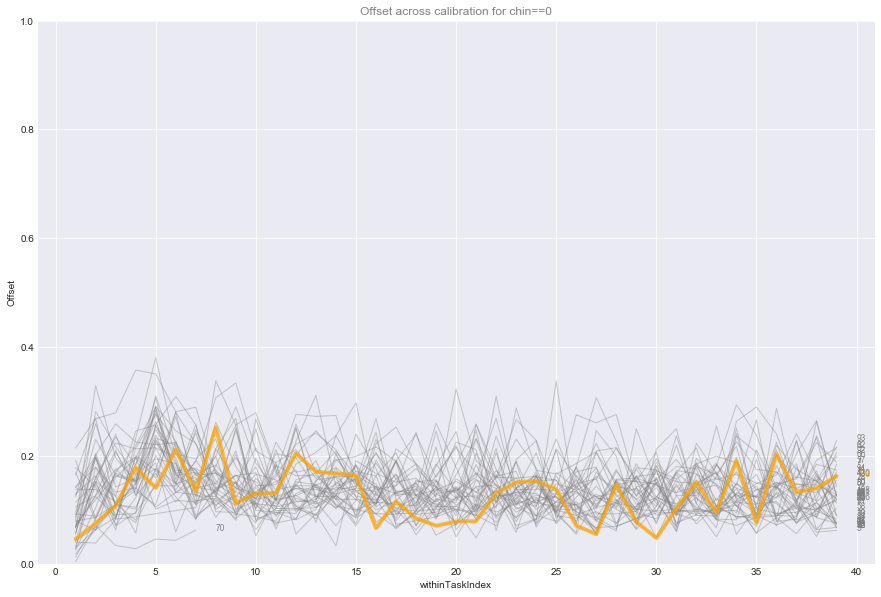

In [81]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==0, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

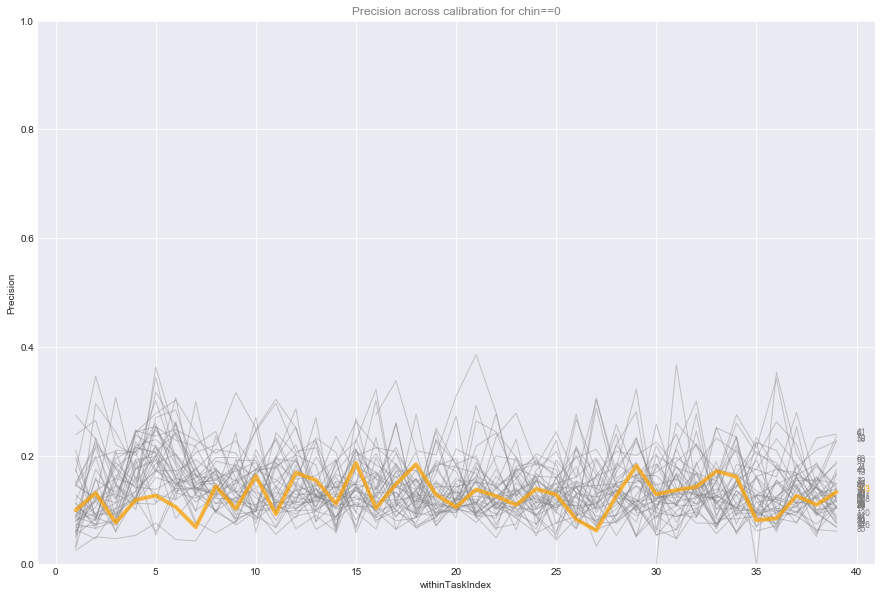

In [82]:
spaghettiPlot(
    data_trial_calibration.loc[data_trial_calibration['chin']==1, :], 
    'withinTaskIndex', 'precision', 103)
plt.ylim(0, 1)
plt.title('Precision across calibration for chin==0', loc='center', fontsize=12, fontweight=0, color='grey')
plt.xlabel('withinTaskIndex')
plt.ylabel('Precision')

plt.show()

## categorical confounders

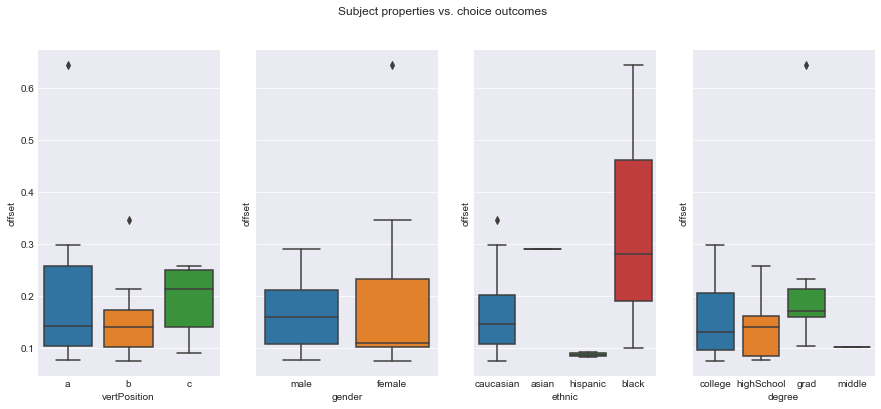

In [83]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='offset', data=data_subject)

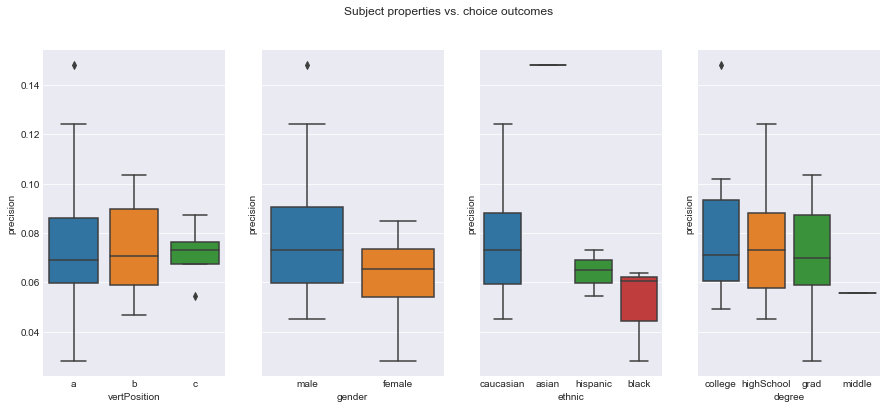

In [84]:
fig, axes = plt.subplots(1, 4, sharey=True, figsize=(3*5, 6))
fig.suptitle('Subject properties vs. choice outcomes')

predictors = [
    'vertPosition',
    'gender',
    'ethnic', 
    'degree'
             ]  
for i in range(0, len(predictors)):
    sns.boxplot(ax=axes[i], x=predictors[i], y='precision', data=data_subject)

# Correlation Plot

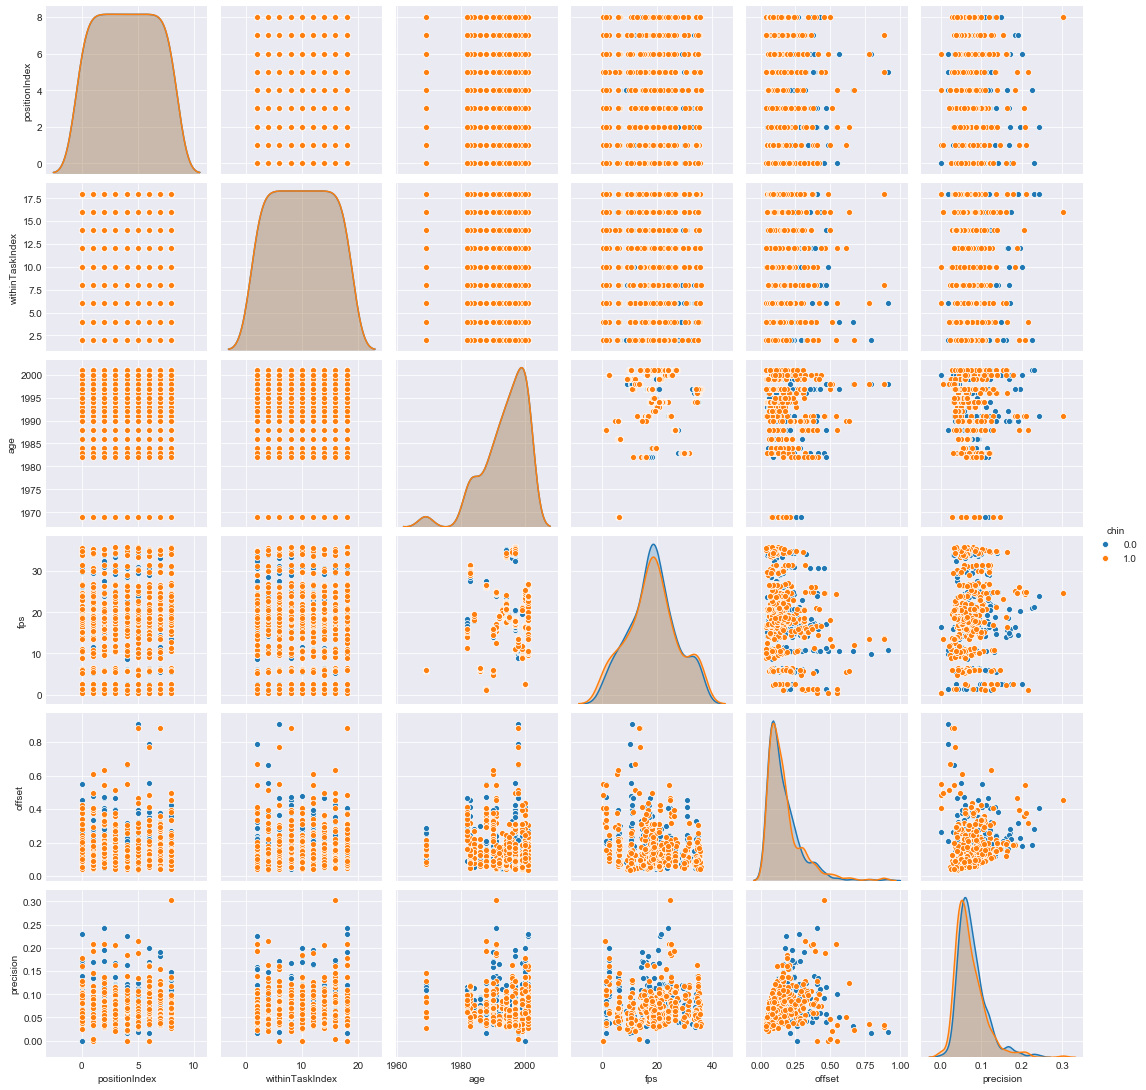

In [340]:
data_plot = data_trial_fix.merge(data_subject.loc[:, ['run_id', 'age']], on='run_id', how='left')
correlation_columns = ['positionIndex', 'withinTaskIndex', 'age', 'fps', 'offset', 'precision']
sns.pairplot(data_plot.loc[:, np.append(correlation_columns, ['chin'])], hue='chin')

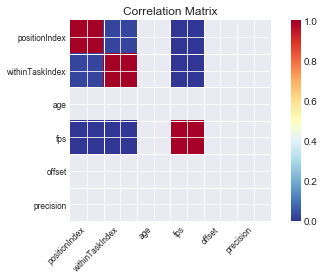

In [342]:
corr_matrix = np.corrcoef(data_plot[correlation_columns].T)
smg.plot_corr(corr_matrix, xnames=correlation_columns)
plt.show()

In [344]:
data_plot[correlation_columns].rcorr()

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,,,,,
withinTaskIndex,0.024,-,,,,
age,0.0,0.0,-,**,**,*
fps,0.002,-0.0,0.125,-,***,
offset,-0.041,0.005,-0.115,-0.247,-,***
precision,-0.031,0.06,-0.081,0.027,0.184,-


In [345]:
data_plot[correlation_columns].rcorr(upper='n')

,positionIndex,withinTaskIndex,age,fps,offset,precision
positionIndex,-,711,684,711,699,699
withinTaskIndex,0.024,-,684,711,699,699
age,0.0,0.0,-,684,678,678
fps,0.002,-0.0,0.125,-,699,699
offset,-0.041,0.005,-0.115,-0.247,-,699
precision,-0.031,0.06,-0.081,0.027,0.184,-


# MLA Model

In [403]:
data_plot = data_trial_fix.loc[:, ['run_id', 'chin', 'x_pos', 'y_pos', 'precision']]
null_data = data_plot.loc[data_plot.isnull().any(axis=1), :]
data_plot = data_plot.loc[pd.notna(data_plot['precision']), :].reset_index(drop=True)
data_plot.loc[data_plot.isnull().any(axis=1), :]
model = smf.mixedlm("precision ~ x_pos", data_plot, groups=data_plot["run_id"])
model_fit = md.fit()
print(model_fit.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Log-Likelihood:     -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.394    2.149                            



# Export

In [ ]:
data_et_fixCal.to_csv("data_jupyter/data_et_fixCal.csv", index=False, header=True)
data_et_calibration.to_csv("data_jupyter/data_et_calibration.csv", index=False, header=True)
data_et_fix.to_csv("data_jupyter/data_et_fix.csv", index=False, header=True)
data_trial_fixCal.to_csv("data_jupyter/data_trial_fixCal.csv", index=False, header=True)
data_trial_calibration.to_csv("data_jupyter/data_trial_calibration.csv", index=False, header=True)
data_trial_fix.to_csv("data_jupyter/data_trial_fix.csv", index=False, header=True)
data_subject.to_csv("data_jupyter/data_subject.csv", index=False, header=True)

# Feedback

In [ ]:
print('Success! Script ran through')